In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
path = '/content/drive/MyDrive/새싹2기/python_DA/data/'

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install koreanize_matplotlib
import koreanize_matplotlib

In [22]:
!pip install lifetimes
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 15.6 MB/s eta 0:00:00


In [23]:
trans = pd.read_csv(path + 'rocket_sample_transactions.csv', parse_dates=['order_date'])

In [24]:
trans.head()

,customer_id,order_date,amount
0,rk_0006,2024-02-13,29606.0
1,rk_0007,2024-01-15,18743.0
2,rk_0010,2024-06-08,23695.0
3,rk_0012,2024-05-12,12278.0
4,rk_0012,2024-01-30,17049.0


In [25]:
rfm = summary_data_from_transaction_data(
                                        trans,
                                        customer_id_col='customer_id',
                                        datetime_col='order_date',
                                        monetary_value_col='amount',
                                        freq='D'
                                    )

In [26]:
trans[trans['customer_id'] == 'rk_0006']

,customer_id,order_date,amount
0,rk_0006,2024-02-13,29606.0


In [27]:
rfm

,frequency,recency,T,monetary_value
customer_id,,,,
rk_0006,0.0,0.0,137.0,0.0
rk_0007,0.0,0.0,166.0,0.0
rk_0010,0.0,0.0,21.0,0.0
rk_0012,1.0,103.0,151.0,12278.0
rk_0014,0.0,0.0,124.0,0.0
...,...,...,...,...
rk_1976,0.0,0.0,9.0,0.0
rk_1977,0.0,0.0,4.0,0.0
rk_1982,0.0,0.0,39.0,0.0


In [28]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf

<lifetimes.BetaGeoFitter>

In [29]:
bgf.fit(rfm['frequency'],rfm['recency'],rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 478 subjects, a: 0.23, alpha: 72.25, b: 0.03, r: 0.25>

In [32]:
rfm['pred_purchases_90d'] =  bgf.predict(
    90, frequency=rfm['frequency'],
    recency = rfm['recency'],
    T=rfm['T'])

In [33]:
rfm['pred_purchases_90d']

,pred_purchases_90d
customer_id,
rk_0006,0.088542
rk_0007,0.079401
rk_0010,0.166051
rk_0012,0.046961
rk_0014,0.093372
...,...
rk_1976,0.183108
rk_1977,0.191367
rk_1982,0.145893


In [34]:
# Step 3: Gamma-Gamma 모델 학습 (평균 지출액 예측)
returning = rfm[rfm['frequency'] > 0]
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(returning['frequency'], returning['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 74 subjects, p: 2.73, q: 0.13, v: 2.53>

In [36]:
ltv = ggf.customer_lifetime_value(
    bgf,
    returning['frequency'],
    returning['recency'],
    returning['T'],
    returning['monetary_value'],
    time=12,
    freq='D',
    discount_rate=0.01
)
returning['LTV_12m'] = ltv

             frequency  monetary_value        LTV_12m
customer_id                                          
rk_1380            2.0         48345.5  208128.123260
rk_1317            2.0         36187.0  122943.825661
rk_0828            2.0         74593.5  102445.296141
rk_1861            1.0        222609.0   86260.272585
rk_1539            1.0         85081.0   54102.342394
rk_0080            1.0        169877.0   46188.408795
rk_1912            1.0        121526.0   38177.649907
rk_0855            1.0         72856.0   36731.656835
rk_1136            1.0         53717.0   18413.483082
rk_1558            1.0         34499.0   14086.912161


In [37]:
returning.nlargest(10, 'LTV_12m')[['frequency', 'monetary_value', 'LTV_12m']]

,frequency,monetary_value,LTV_12m
customer_id,,,
rk_1380,2.0,48345.5,208128.123260
rk_1317,2.0,36187.0,122943.825661
rk_0828,2.0,74593.5,102445.296141
rk_1861,1.0,222609.0,86260.272585
rk_1539,1.0,85081.0,54102.342394
rk_0080,1.0,169877.0,46188.408795
rk_1912,1.0,121526.0,38177.649907
rk_0855,1.0,72856.0,36731.656835
rk_1136,1.0,53717.0,18413.483082


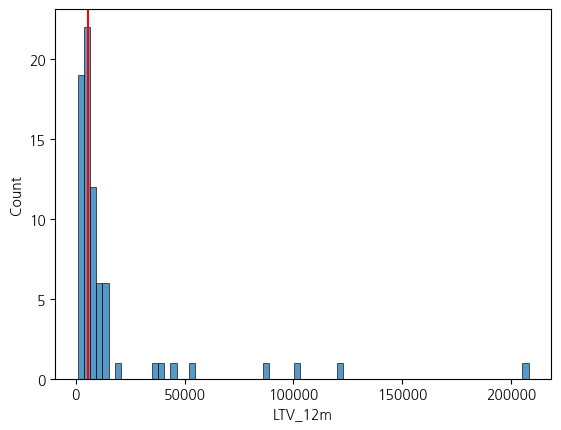

In [39]:
sns.histplot(returning['LTV_12m'])
plt.axvline(returning['LTV_12m'].median(),color='red')

In [40]:
returning['LTV_12m'].median()

5812.745144898213